# **HUMAN ACTIVITY RECOGNITION**
### **Group 160 - DL Assignment II**
1.  Sagnik Ghosh          2018ah04573
2.  K Laxmi Narasimha Rao 2018ah04599
3.  M Naveen              2018ah04543 


# **1. Import Required Libraries**

In [7]:
import pandas as pd
import keras

import numpy as np

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from numpy import dstack
from pandas import read_csv

from keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from numpy import mean
from numpy import std
from numpy import dstack
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [8]:
!nvidia-smi

Tue Jan 19 15:50:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    34W /  70W |    229MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [10]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1tnQPfAconuACqRfIm0lC7zwJFd0LFj8N'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

Downloaded content "Hellow World"


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
#Check the GPU available
tf.test.gpu_device_name()

'/device:GPU:0'

In [13]:
import os
os.chdir('/content/drive/My Drive/HARDataset/train/Inertial Signals')

In [14]:
!pwd

/content/drive/My Drive/HARDataset/train/Inertial Signals


In [15]:
from pandas import read_csv
body_acc_x=read_csv('body_acc_x_train.txt', header=None, delim_whitespace=True)

### Load a single file as a numpy array

# **2.  Data Pre-Processing**

In [16]:
# load a single file as a numpy array
def load_file(filepath):
  print (filepath)
  dataframe = read_csv(filepath, header=None, delim_whitespace=True)
  return dataframe.values

### Load a list of files and return as a 3d numpy array

In [17]:
def load_group(filenames, prefix=''):
  loaded = list()
  for name in filenames:
    data = load_file(prefix + name)
    loaded.append(data)
  # stack group so that features are the 3rd dimension
  loaded = dstack(loaded)
  return loaded

### Load a dataset group, such as train or test

In [18]:

def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y



### Load the dataset, returns train and test X and y elements

In [19]:

def load_dataset(prefix='/content/drive/My Drive/'):
#def load_dataset(prefix='C:/Saggy/hahaha/Courses/BITS_Pilani_DataScience/Semester3/DL/Assignments/2/assginment_2/'):  
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy




In [20]:
trainX, trainy, testX, testy = load_dataset()

/content/drive/My Drive/HARDataset/train/Inertial Signals/total_acc_x_train.txt
/content/drive/My Drive/HARDataset/train/Inertial Signals/total_acc_y_train.txt
/content/drive/My Drive/HARDataset/train/Inertial Signals/total_acc_z_train.txt
/content/drive/My Drive/HARDataset/train/Inertial Signals/body_acc_x_train.txt
/content/drive/My Drive/HARDataset/train/Inertial Signals/body_acc_y_train.txt
/content/drive/My Drive/HARDataset/train/Inertial Signals/body_acc_z_train.txt
/content/drive/My Drive/HARDataset/train/Inertial Signals/body_gyro_x_train.txt
/content/drive/My Drive/HARDataset/train/Inertial Signals/body_gyro_y_train.txt
/content/drive/My Drive/HARDataset/train/Inertial Signals/body_gyro_z_train.txt
/content/drive/My Drive/HARDataset/train/y_train.txt
(7352, 128, 9) (7352, 1)
/content/drive/My Drive/HARDataset/test/Inertial Signals/total_acc_x_test.txt
/content/drive/My Drive/HARDataset/test/Inertial Signals/total_acc_y_test.txt
/content/drive/My Drive/HARDataset/test/Inertial 

In [21]:
trainX

array([[[ 1.012817e+00, -1.232167e-01,  1.029341e-01, ...,
          3.019122e-02,  6.601362e-02,  2.285864e-02],
        [ 1.022833e+00, -1.268756e-01,  1.056872e-01, ...,
          4.371071e-02,  4.269897e-02,  1.031572e-02],
        [ 1.022028e+00, -1.240037e-01,  1.021025e-01, ...,
          3.568780e-02,  7.485018e-02,  1.324969e-02],
        ...,
        [ 1.018445e+00, -1.240696e-01,  1.003852e-01, ...,
          3.985177e-02,  1.909445e-03, -2.170124e-03],
        [ 1.019372e+00, -1.227451e-01,  9.987355e-02, ...,
          3.744932e-02, -7.982483e-05, -5.642633e-03],
        [ 1.021171e+00, -1.213260e-01,  9.498741e-02, ...,
          2.881781e-02, -3.771800e-05, -1.446006e-03]],

       [[ 1.018851e+00, -1.239760e-01,  9.792958e-02, ...,
          1.711106e-02,  6.122797e-03,  1.226815e-02],
        [ 1.022380e+00, -1.268078e-01,  9.935086e-02, ...,
          2.417851e-02,  9.710357e-03,  1.614958e-02],
        [ 1.020781e+00, -1.277862e-01,  9.811381e-02, ...,
          3.02

In [22]:
trainy

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [23]:
a = np.array((1,2,3,4,5,6,7,8))
b = np.array((11,21,31,41,51,61,71,81))
c = np.array((21,31,41,51,61,71,81,91))
np.dstack((a,b,c))

array([[[ 1, 11, 21],
        [ 2, 21, 31],
        [ 3, 31, 41],
        [ 4, 41, 51],
        [ 5, 51, 61],
        [ 6, 61, 71],
        [ 7, 71, 81],
        [ 8, 81, 91]]])

In [24]:
trainX.shape

(7352, 128, 9)

In [25]:
df_activity=read_csv('/content/drive/My Drive/HARDataset/train/y_train.txt', header=None, delim_whitespace=True)

# **3. Visualization**

In [26]:
labels_to_activity = {1:"Walking",2:"Walking Upstairs",3:"Walking Downstairs",
                    4:"Sitting",5:"Standing",6:"Laying"}

def label_decoder(label):
  return labels_to_activity[label]

df_activity['activity'] = df_activity[0].apply(lambda x:label_decoder(x))

In [27]:
df_activity['activity'].value_counts()

Laying                1407
Standing              1374
Sitting               1286
Walking               1226
Walking Upstairs      1073
Walking Downstairs     986
Name: activity, dtype: int64

Text(0.5, 1.0, 'Activity Data Distribution')

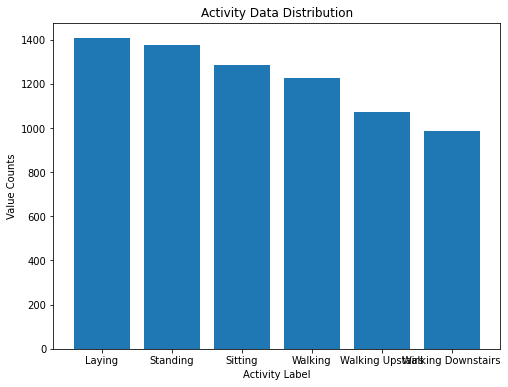

In [28]:
val_counts = df_activity['activity'].value_counts()

plt.figure(figsize=(8,6))
plt.bar(val_counts.index,val_counts.values)
plt.xlabel("Activity Label")
plt.ylabel("Value Counts")
plt.title("Activity Data Distribution")

In [29]:
body_acc_x=read_csv('body_acc_x_train.txt', header=None, delim_whitespace=True)
body_acc_y=read_csv('body_acc_y_train.txt', header=None, delim_whitespace=True)
body_acc_z=read_csv('body_acc_z_train.txt', header=None, delim_whitespace=True)
total_acc_x=read_csv('total_acc_x_train.txt', header=None, delim_whitespace=True)
total_acc_y=read_csv('total_acc_y_train.txt', header=None, delim_whitespace=True)
total_acc_z=read_csv('total_acc_z_train.txt', header=None, delim_whitespace=True)
body_gyro_x=read_csv('body_gyro_x_train.txt', header=None, delim_whitespace=True)
body_gyro_y=read_csv('body_gyro_y_train.txt', header=None, delim_whitespace=True)
body_gyro_z=read_csv('body_gyro_z_train.txt', header=None, delim_whitespace=True)

In [30]:
df_v_all = np.dstack((body_acc_x,body_acc_y,body_acc_z,total_acc_x,total_acc_y,total_acc_z,body_gyro_x,body_gyro_y,body_gyro_z))
df_v_all.shape

(7352, 128, 9)

# **Model 1**

*AT LEAST 2 LSTM layers with 90 units*

*Add one layer of dropout*

*Use AT LEAST 2 dense layers (one with 90 units and one for output)*


### **1.1 Model-1 Building**

In [31]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
print(n_timesteps,n_features,n_outputs)
epochs=20
batch_size=64
verbose=1
model_1 = Sequential()
model_1.add(LSTM(90, input_shape=(n_timesteps,n_features),return_sequences=True))
model_1.add(Dropout(0.1))
model_1.add(LSTM(90, input_shape=(n_timesteps,n_features)))
model_1.add(Dropout(0.5))
model_1.add(Dense(90, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(n_outputs, activation='softmax'))
 

128 9 6


## DROP OUT :


```
#1 Drop Out Layer Prevents Overfitting , Also prevents complex co-adaptations
#2 Drop Out Needs to be added - After LSTM Layers
#2 Drop Makes the Model Robust

** Drop out Should be places Outside the LSTM Layers, so that drop outs does not reduce learning or does not make learning certain things**
Some Recent Research Shown good results , when Drop Out is added in LSTM Layers.
with Low Dropout values (0.1,0.2)
But Generally Drop Outs are added at the end of block or LSTM or RNN Layers
```



### **1.2 Model-1 Compilation** 

In [32]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### **1.3 Model-1 Training**

In [33]:
history = model_1.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/20
115/115 [==============================] - 11s 15ms/step - loss: 1.4064 - accuracy: 0.4167
Epoch 2/20
115/115 [==============================] - 2s 14ms/step - loss: 0.7755 - accuracy: 0.6613
Epoch 3/20
115/115 [==============================] - 2s 14ms/step - loss: 0.6492 - accuracy: 0.7518
Epoch 4/20
115/115 [==============================] - 2s 14ms/step - loss: 0.3695 - accuracy: 0.8722
Epoch 5/20
115/115 [==============================] - 2s 14ms/step - loss: 0.3025 - accuracy: 0.8984
Epoch 6/20
115/115 [==============================] - 2s 14ms/step - loss: 0.2242 - accuracy: 0.9294
Epoch 7/20
115/115 [==============================] - 2s 14ms/step - loss: 0.1693 - accuracy: 0.9424
Epoch 8/20
115/115 [==============================] - 2s 14ms/step - loss: 0.1418 - accuracy: 0.9493
Epoch 9/20
115/115 [==============================] - 2s 14ms/step - loss: 0.1595 - accuracy: 0.9413
Epoch 10/20
115/115 [==============================] - 2s 14ms/step - loss: 0.2543 - accur

### **1.4 Model-1 Evaluation**

In [34]:
accuracy = model_1.evaluate(testX, testy, batch_size=batch_size, verbose=1)
print(f'Test loss for Keras ReLU : {accuracy[0]} / Test accuracy: {accuracy[1]}')


47/47 [==============================] - 1s 7ms/step - loss: 0.3491 - accuracy: 0.9199
Test loss for Keras ReLU : 0.3490807116031647 / Test accuracy: 0.9199185371398926


In [35]:
print('Final training loss \t', history.history['loss'][-1])
print('Final training accuracy ', history.history['accuracy'][-1])

Final training loss 	 0.11873096972703934
Final training accuracy  0.948993444442749


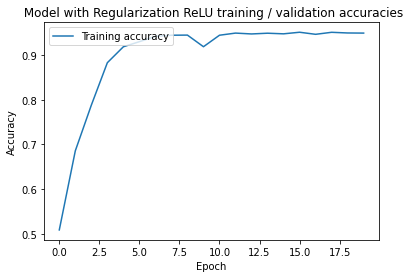

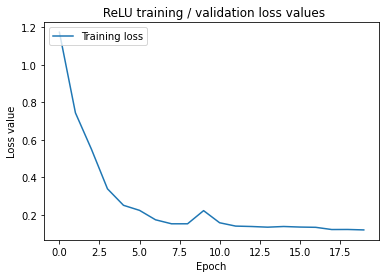

In [36]:
# Visualize model history
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.title(' Model with Regularization ReLU training / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.title(' ReLU training / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [37]:
y_pred = model_1.predict(testX)

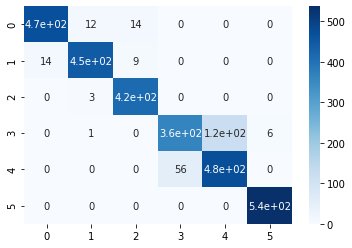

In [38]:
b = np.zeros_like(y_pred)
b[np.arange(len(y_pred)), y_pred.argmax(1)] = 1

pred_label = tf.argmax(b, axis = 1)+1

c = np.zeros_like(testy)
c[np.arange(len(testy)), testy.argmax(1)] = 1
act_label = tf.argmax(c, axis = 1)+1


cf_matrix = confusion_matrix(act_label, pred_label)

  
sns.heatmap(cf_matrix, annot=True,cmap='Blues')

# **Model 2**

### **1. Model-2 Building**

In [39]:
trainX1, trainy1, testX1, testy1 = load_dataset()

/content/drive/My Drive/HARDataset/train/Inertial Signals/total_acc_x_train.txt
/content/drive/My Drive/HARDataset/train/Inertial Signals/total_acc_y_train.txt
/content/drive/My Drive/HARDataset/train/Inertial Signals/total_acc_z_train.txt
/content/drive/My Drive/HARDataset/train/Inertial Signals/body_acc_x_train.txt
/content/drive/My Drive/HARDataset/train/Inertial Signals/body_acc_y_train.txt
/content/drive/My Drive/HARDataset/train/Inertial Signals/body_acc_z_train.txt
/content/drive/My Drive/HARDataset/train/Inertial Signals/body_gyro_x_train.txt
/content/drive/My Drive/HARDataset/train/Inertial Signals/body_gyro_y_train.txt
/content/drive/My Drive/HARDataset/train/Inertial Signals/body_gyro_z_train.txt
/content/drive/My Drive/HARDataset/train/y_train.txt
(7352, 128, 9) (7352, 1)
/content/drive/My Drive/HARDataset/test/Inertial Signals/total_acc_x_test.txt
/content/drive/My Drive/HARDataset/test/Inertial Signals/total_acc_y_test.txt
/content/drive/My Drive/HARDataset/test/Inertial 

In [40]:
Model_t3 = models.Sequential()
    
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
print("TimeSteps",n_timesteps, n_features, n_outputs)
n_steps, n_length = 128, 1
trainX1 = trainX1.reshape((trainX1.shape[0], n_steps, 1, n_length, n_features))
testX1 = testX1.reshape((testX1.shape[0], n_steps, 1, n_length, n_features))


Model_t3.add(layers.Conv2D(256, (1,3), activation="relu", input_shape=(trainX1.shape[0], 128, n_length, n_features),padding="same" ))
Model_t3.add(layers.Conv2D(256, (1,3), activation="relu", input_shape=(trainX1.shape[0], 128, n_length, n_features),padding="same" ))
   
Model_t3.add(Flatten())
model_t4 = Sequential()
model_t4.add(TimeDistributed(Model_t3))
model_t4.add(LSTM(80,input_shape=(n_timesteps,n_features),return_sequences=True))
model_t4.add(LSTM(80,input_shape=(n_timesteps,n_features),return_sequences=True))
model_t4.add(Flatten())
model_t4.add(Dense(128, activation='relu'))
model_t4.add(Dense(n_outputs, activation='softmax'))


TimeSteps 128 9 6


In [41]:
trainX.shape

(7352, 128, 9)

### **2. Model-2 Compilation**

In [42]:
model_t4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### **3. Model-2 Training**

In [43]:
history = model_t4.fit(trainX1, trainy1, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/20
115/115 [==============================] - 6s 22ms/step - loss: 0.8269 - accuracy: 0.6419
Epoch 2/20
115/115 [==============================] - 2s 19ms/step - loss: 0.2014 - accuracy: 0.9241
Epoch 3/20
115/115 [==============================] - 2s 19ms/step - loss: 0.1492 - accuracy: 0.9379
Epoch 4/20
115/115 [==============================] - 2s 19ms/step - loss: 0.1644 - accuracy: 0.9359
Epoch 5/20
115/115 [==============================] - 2s 19ms/step - loss: 0.1390 - accuracy: 0.9448
Epoch 6/20
115/115 [==============================] - 2s 19ms/step - loss: 0.1179 - accuracy: 0.9507
Epoch 7/20
115/115 [==============================] - 2s 19ms/step - loss: 0.1022 - accuracy: 0.9581
Epoch 8/20
115/115 [==============================] - 2s 19ms/step - loss: 0.1039 - accuracy: 0.9542
Epoch 9/20
115/115 [==============================] - 2s 19ms/step - loss: 0.1054 - accuracy: 0.9513
Epoch 10/20
115/115 [==============================] - 2s 19ms/step - loss: 0.0957 - accura

### **4. Model-2 Evaluation**

In [44]:
accuracy = model_t4.evaluate(testX1, testy1, batch_size=batch_size, verbose=verbose)
print(f'Test loss for Keras ReLU : {accuracy[0]} / Test accuracy: {accuracy[1]}')


47/47 [==============================] - 1s 8ms/step - loss: 0.8421 - accuracy: 0.9094
Test loss for Keras ReLU : 0.8421382904052734 / Test accuracy: 0.9093993902206421


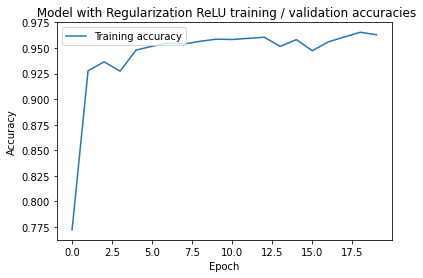

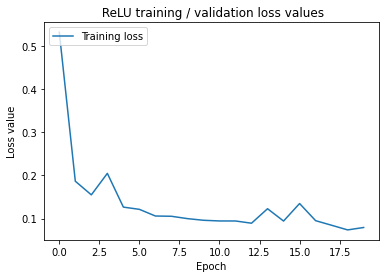

In [45]:
# Visualize model history
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.title(' Model with Regularization ReLU training / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.title(' ReLU training / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

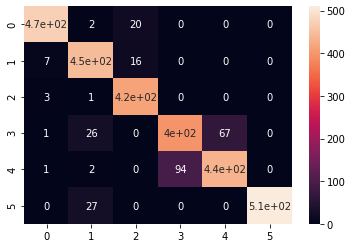

In [46]:

y_pred = model_t4.predict(testX1)

b = np.zeros_like(y_pred)
b[np.arange(len(y_pred)), y_pred.argmax(1)] = 1

pred_label = tf.argmax(b, axis = 1)+1

c = np.zeros_like(testy1)
c[np.arange(len(testy1)), testy1.argmax(1)] = 1
act_label = tf.argmax(c, axis = 1)+1


cf_matrix = confusion_matrix(act_label, pred_label)

  
sns.heatmap(cf_matrix, annot=True)
